In [1]:
import mne
from pathlib import Path

from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci

path = Path(r"C:\Users\erik\IES_codebase\pythonProjects\EEG_Exoskeleton\data\raw_data")

In [ ]:
raw_fnames = []

subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# create a list from 1 to 109
subjects = list(range(1, 109))

runs = [6, 10, 14]

for sub in subjects:
    fname = eegbci.load_data(subject=sub, runs=runs, path=path)
    raw_fnames.extend(fname)

raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
raw = concatenate_raws(raws)

raw.rename_channels(lambda x: x.strip("."))  # remove dots from channel names
# rename descriptions to be more easily interpretable
raw.annotations.rename(dict(T1="hands", T2="feet"))

montage = mne.channels.make_standard_montage("standard_1005")

mne.datasets.eegbci.standardize(raw)  # set channel names
raw.set_montage(montage, verbose=False)

In [3]:
tmin, tmax = -1, 4
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks

In [4]:
epochs = mne.Epochs(
    raw,
    event_id=["hands", "feet"],
    tmin=tmin - 0.5,
    tmax=tmax + 0.5,
    baseline=None,
    preload=True,
)

Used Annotations descriptions: ['T0', 'feet', 'hands']
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
450 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 450 events and 961 original time points ...
21 bad epochs dropped


In [5]:
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

In [6]:
epochs_data = epochs.get_data(copy=False)
epochs_data_train = epochs_train.get_data(copy=False)

In [7]:
labels.shape

(429,)

In [8]:
epochs_data_train.shape

(429, 64, 161)

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the input shape
input_shape = (64, 161)

# Build the model
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Flatten(),  # Flatten the input
    layers.Dense(1280, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(640, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 10304)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1280)           │    13,190,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 640)            │       819,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,092,417 (53.76 MB)

 Trainable params: 14,092,417 (53.76 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
history = model.fit(
    epochs_data_train,
    labels,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.5154 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.4532 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.4936 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.4653 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.4870 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.4734 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.5168 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.4285 - loss: 0.6953 - val_accuracy: 0.5000 - val_loss:

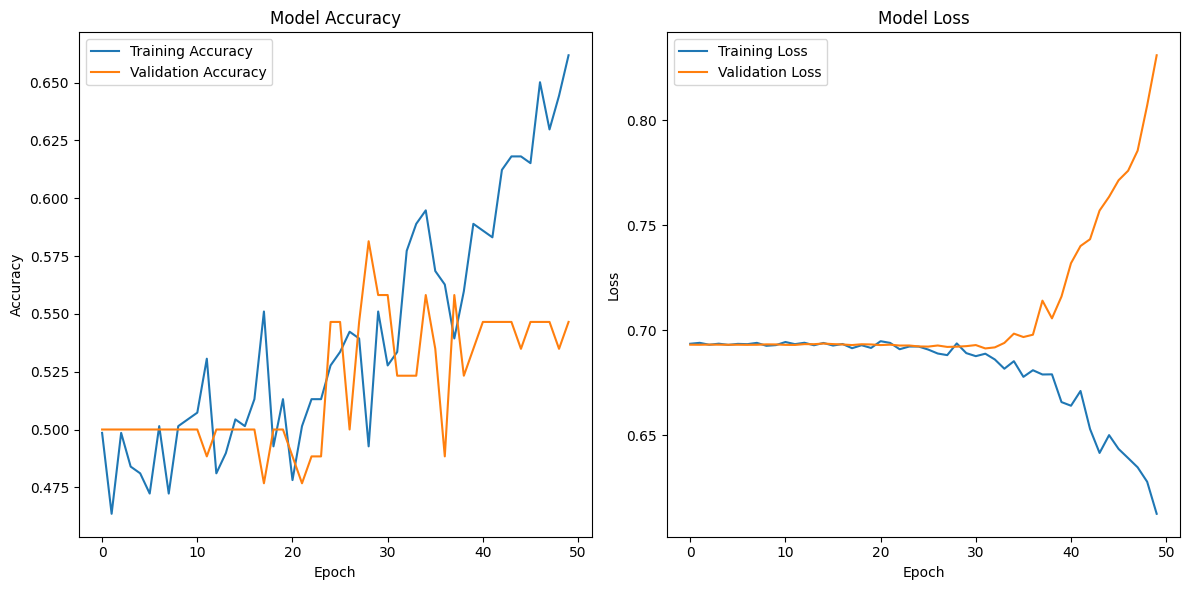

In [14]:
import matplotlib.pyplot as plt

# Plot the learning curve
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()